# Load Data & Packages

Goal : To predict if two real estate listings are the same without using location variables of any sort 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fancyimpute
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv("trainListings.csv" , error_bad_lines = False)
#location = pd.read_csv("locations.csv")
matches = pd.read_csv("trainMatchedListings.csv")
#test = pd.read_csv('testListings.csv')
#types = pd.read_csv("types.csv")

b'Skipping line 71425: expected 18 fields, saw 20\nSkipping line 71499: expected 18 fields, saw 46\nSkipping line 71692: expected 18 fields, saw 25\nSkipping line 71968: expected 18 fields, saw 20\nSkipping line 82992: expected 18 fields, saw 24\n'
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Fix Matches df
matches.reset_index(inplace=True)
matches = matches.rename(columns={'index': 'id1', 'id1': 'id2' , 'id2':'target'})

## See missing values

In [5]:
df.isnull().sum()/len(df)

id             0.000000
sourceId       0.000024
locationId     0.000084
typeId         0.000024
price          0.074367
rooms          0.897806
bedrooms       0.154646
bathrooms      0.178487
totalArea      0.317166
livingArea     0.627673
plotArea       0.467127
terraceArea    0.793770
title          0.051850
description    0.034474
features       0.490319
latitude       0.808292
longitude      0.811061
thumbnails     0.000048
dtype: float64

There are a few variables that have a large percentage of missing values. We can drop them from our analysis. We'll also drop thumbnails but we may need them back if we do some neural network stuff. 

Variables to drop: Rooms, Living Area , PlotArea, Terrace Area, Features, Latitude/Longitude, Features

In [6]:
df.drop(['rooms', 'livingArea' , 'plotArea' , 'terraceArea' , 'latitude' , 'longitude', 'features' , 'thumbnails'], axis=1, inplace=True)

In [7]:
df.shape

(83048, 10)

## Box Plots

In [8]:
df.columns

Index(['id', 'sourceId', 'locationId', 'typeId', 'price', 'bedrooms', 'bathrooms', 'totalArea', 'title', 'description'], dtype='object')

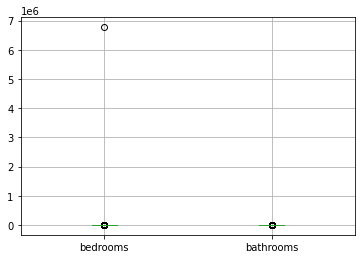

In [9]:
df.boxplot(column=['bedrooms' , 'bathrooms'] , return_type='axes');
# Note we have one massive outlier with 6.7 millions bedrooms..let's go ahead and drop this.

In [10]:
df[df['totalArea'] > 1000000]
df.drop(74487,inplace=True)

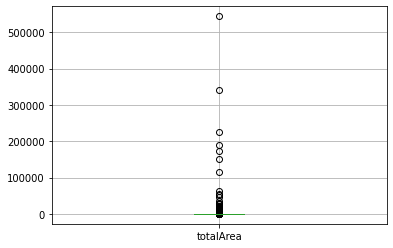

In [11]:
df.boxplot(column=['totalArea'] , return_type='axes');
# There are a few outliers toward the tail ends which are fine however the last two are significantly larger which may disrupt our results. Let's go ahead and drop them 

In [12]:
df[df['totalArea'] > 200000]
df.drop([72677,75337],inplace=True)

We will look at the distrubutions and boxplots of price later on in the analysis

## Generate General Dataframe to build from. 

#### Idea here is that each row should have features regarding both listings because we have to train our model in such a way that it takes info on both listings and then tries to see if they are the same

In [13]:
new = matches.merge(df,left_on='id1',right_on='id')

In [14]:
new.drop('id',inplace=True , axis = 1)
new.columns = ['id1', 'id2', 'target', 'sourceid_id1', 'locationid_id1', 'type_id1','price_id1','bedrooms_id1','bathrooms_id1','totalArea_id1','title_id1','description_id1']

In [15]:
updated = new.merge(df, left_on='id2' , right_on ='id')

In [16]:
updated.drop('id',inplace=True , axis = 1)
updated.columns = ['id1', 'id2', 'target', 'sourceid_id1', 'locationid_id1', 'type_id1','price_id1','bedrooms_id1','bathrooms_id1','totalArea_id1','title_id1','description_id1',
                    'sourceid_id2', 'locationid_id2', 'type_id2','price_id2','bedrooms_id2','bathrooms_id2','totalArea_id2','title_id2','description_id2']

In [17]:
df = updated.copy()

In [18]:
df[['price_id1', 'price_id2']] = df[['price_id1', 'price_id2']].astype(float)

In [19]:
df.head()

,id1,id2,target,sourceid_id1,locationid_id1,type_id1,price_id1,bedrooms_id1,bathrooms_id1,totalArea_id1,title_id1,description_id1,sourceid_id2,locationid_id2,type_id2,price_id2,bedrooms_id2,bathrooms_id2,totalArea_id2,title_id2,description_id2
0,1,2,1,1.0,84.0,4.0,26500000.0,10.0,16.0,4000.0,Exquisite manor house amidst the Tramontana va...,"Strength, tradition and serenity around 10,000...",9.0,84.0,4.0,26500000.0,10.0,12.0,3000.0,Finca in Puigpunyent (Objektnummer KSV00142),Magnificent Mallorquinian Mansion of XVII cent...
1,3,2,1,14.0,84.0,12.0,26500000.0,10.0,12.0,3000.0,Magnificent Mallorquinian Mansion of XVII cent...,Magnificent Mallorquinian Mansion of XVII cent...,9.0,84.0,4.0,26500000.0,10.0,12.0,3000.0,Finca in Puigpunyent (Objektnummer KSV00142),Magnificent Mallorquinian Mansion of XVII cent...
2,4,2,1,37.0,84.0,10.0,26500000.0,10.0,12.0,3000.0,Magnificent Mallorquinian Mansion of XVII cent...,Magnificent Mallorquinian Mansion of XVII cent...,9.0,84.0,4.0,26500000.0,10.0,12.0,3000.0,Finca in Puigpunyent (Objektnummer KSV00142),Magnificent Mallorquinian Mansion of XVII cent...
3,5,2,1,85.0,84.0,10.0,26500000.0,10.0,12.0,NaN,Mallorquinian Mansion of XVII century on the m...,Magnificent Mallorquinian Mansion of XVII cent...,9.0,84.0,4.0,26500000.0,10.0,12.0,3000.0,Finca in Puigpunyent (Objektnummer KSV00142),Magnificent Mallorquinian Mansion of XVII cent...
4,6,2,1,8.0,84.0,5.0,26500000.0,10.0,16.0,4000.0,Unique Majorcan Rural Estate in Puigpunyent,"Description\n\t\t\t\tThis magnificent, totally...",9.0,84.0,4.0,26500000.0,10.0,12.0,3000.0,Finca in Puigpunyent (Objektnummer KSV00142),Magnificent Mallorquinian Mansion of XVII cent...


In [20]:
df.columns

Index(['id1', 'id2', 'target', 'sourceid_id1', 'locationid_id1', 'type_id1', 'price_id1', 'bedrooms_id1', 'bathrooms_id1', 'totalArea_id1', 'title_id1', 'description_id1', 'sourceid_id2', 'locationid_id2', 'type_id2', 'price_id2', 'bedrooms_id2', 'bathrooms_id2', 'totalArea_id2', 'title_id2', 'description_id2'], dtype='object')

#### Create dummy variables for different types of properties -> Apartments, Houses, Plots, Investment & Other (Have to do for both ID1 and ID2)

In [21]:
apartment_dummy_1 = []
for i in df['type_id1']:
    if i == 1 or i == 2 or i == 3 or i == 7:
        apartment_dummy_1.append(1)
    else:
        apartment_dummy_1.append(0)
        
house_dummy_1 = []
for i in df['type_id1']:
    if i == 4 or i == 5 or i == 6 or i == 9 or i == 10 or i == 12:
        house_dummy_1.append(1)
    else:
        house_dummy_1.append(0)
        
plot_dummy_1 = []
for i in df['type_id1']:
    if i == 8:
        plot_dummy_1.append(1)
    else:
        plot_dummy_1.append(0)
        
investment_dummy_1 = []
for i in df['type_id1']:
    if i == 16 or i == 17 or 1 == 18:
        investment_dummy_1.append(1)
    else:
        investment_dummy_1.append(0)

other_dummy_1 = []
for i in df['type_id1']:
    if i == 15:
        other_dummy_1.append(1)
    else:
        other_dummy_1.append(0)
        
# Add to our dataframe 
df['apartment_dummy_1'] = apartment_dummy_1
df['house_dummy_1'] = house_dummy_1
df['plot_dummy_1'] = plot_dummy_1
df['investment_dummy_1'] = investment_dummy_1
df['other_dummy_1'] = other_dummy_1

In [22]:
apartment_dummy_2 = []
for i in df['type_id2']:
    if i == 1 or i == 2 or i == 3 or i == 7:
        apartment_dummy_2.append(1)
    else:
        apartment_dummy_2.append(0)
        
house_dummy_2 = []
for i in df['type_id2']:
    if i == 4 or i == 5 or i == 6 or i == 9 or i == 10 or i == 12:
        house_dummy_2.append(1)
    else:
        house_dummy_2.append(0)
        
plot_dummy_2 = []
for i in df['type_id2']:
    if i == 8:
        plot_dummy_2.append(1)
    else:
        plot_dummy_2.append(0)
        
investment_dummy_2 = []
for i in df['type_id2']:
    if i == 16 or i == 17 or 1 == 18:
        investment_dummy_2.append(1)
    else:
        investment_dummy_2.append(0)

other_dummy_2 = []
for i in df['type_id2']:
    if i == 15:
        other_dummy_2.append(1)
    else:
        other_dummy_2.append(0)
        
# Add to our dataframe 
df['apartment_dummy_2'] = apartment_dummy_2
df['house_dummy_2'] = house_dummy_2
df['plot_dummy_2'] = plot_dummy_2
df['investment_dummy_2'] = investment_dummy_2
df['other_dummy_2'] = other_dummy_2

Dropping more columns as we won't need these ones
* id1 & id2 -> we've merged our dataframe now there is no use for them
* Sourceid_id1 & Sourceid_id2 are just the agency ID for each posting so they don't add any value
* Type_id1 & Type_id2 told us what type of property it was & now that we've one hot encoded them we can drop this column
* Locationid_id1 & Locationid_id2

In [23]:
df.columns

Index(['id1', 'id2', 'target', 'sourceid_id1', 'locationid_id1', 'type_id1', 'price_id1', 'bedrooms_id1', 'bathrooms_id1', 'totalArea_id1', 'title_id1', 'description_id1', 'sourceid_id2', 'locationid_id2', 'type_id2', 'price_id2', 'bedrooms_id2', 'bathrooms_id2', 'totalArea_id2', 'title_id2', 'description_id2', 'apartment_dummy_1', 'house_dummy_1', 'plot_dummy_1', 'investment_dummy_1', 'other_dummy_1', 'apartment_dummy_2', 'house_dummy_2', 'plot_dummy_2', 'investment_dummy_2', 'other_dummy_2'], dtype='object')

In [24]:
df.drop(['id1' , 'id2' , 'sourceid_id1' , 'sourceid_id2' , 'type_id1' , 'type_id2' , 'locationid_id1' , 'locationid_id2'] , axis=1 , inplace=True)

In [25]:
df.isnull().sum()/len(df)

target                0.000000
price_id1             0.132956
bedrooms_id1          0.030750
bathrooms_id1         0.058354
totalArea_id1         0.251712
title_id1             0.040496
description_id1       0.042926
price_id2             0.124206
bedrooms_id2          0.031141
bathrooms_id2         0.079075
totalArea_id2         0.208011
title_id2             0.035146
description_id2       0.032806
apartment_dummy_1     0.000000
house_dummy_1         0.000000
plot_dummy_1          0.000000
investment_dummy_1    0.000000
other_dummy_1         0.000000
apartment_dummy_2     0.000000
house_dummy_2         0.000000
plot_dummy_2          0.000000
investment_dummy_2    0.000000
other_dummy_2         0.000000
dtype: float64

Drop any rows with:
* Mising Description and title 
* Missing bedrooms and bathrooms

Reason is that there is only about 5% of missing values for these columns which isn't too severe 

In [26]:
df.shape

(964854, 23)

In [27]:
df.dropna(subset = ['bedrooms_id1', 'bedrooms_id2' , 'bathrooms_id1' , 'bathrooms_id2' , 'title_id1' , 'title_id2' , 'description_id1' , 'description_id2'] , inplace=True)

In [28]:
df.shape

(718129, 23)

In [29]:
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

In [30]:
df.columns

Index(['target', 'price_id1', 'bedrooms_id1', 'bathrooms_id1', 'totalArea_id1', 'title_id1', 'description_id1', 'price_id2', 'bedrooms_id2', 'bathrooms_id2', 'totalArea_id2', 'title_id2', 'description_id2', 'apartment_dummy_1', 'house_dummy_1', 'plot_dummy_1', 'investment_dummy_1', 'other_dummy_1', 'apartment_dummy_2', 'house_dummy_2', 'plot_dummy_2', 'investment_dummy_2', 'other_dummy_2'], dtype='object')

#### More Box Plots

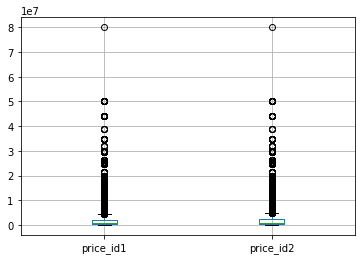

In [31]:
df.boxplot(column=['price_id1','price_id2'], return_type='axes');
# Lets drop that one large outlier

In [32]:
#df[(df['price_id1'] > 50000000)]
#df[(df['price_id2'] > 50000000)]
df.drop([655684,655685],inplace=True)

In [33]:
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

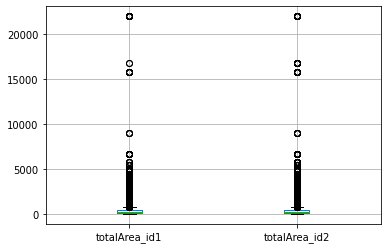

In [34]:
df.boxplot(column=['totalArea_id1','totalArea_id2'], return_type='axes');

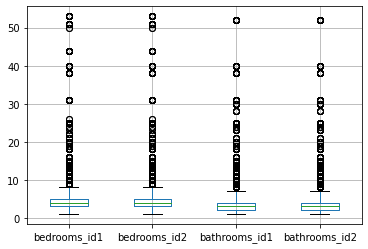

In [35]:
df.boxplot(column=['bedrooms_id1','bedrooms_id2' , 'bathrooms_id1' , 'bathrooms_id2'], return_type='axes');

Our boxplots for the total area and bathrooms/bedrooms are much more cleaner now and nicely distributed when we took away the extreme outliers. Next we will impute the missing values using the MICE method.

## Here is where we will split our dataframe into a Train/Test. 

#### We are imputing our missing values so we can't information from our training set impacting the missing values in the test set

In [95]:
# Split will be 70% train & 30% test. Our target variable is in our dataframe so no need to take it out now, we can take it out when actually implement our model.
# len(df) = 718127
train = df[:502689]
test = df[502689:]
test.reset_index(inplace=True , drop=True)

In [53]:
print(test.shape , train.shape)

(215438, 23) (502689, 23)


In [96]:
test

,target,price_id1,bedrooms_id1,bathrooms_id1,totalArea_id1,title_id1,description_id1,price_id2,bedrooms_id2,bathrooms_id2,totalArea_id2,title_id2,description_id2,apartment_dummy_1,house_dummy_1,plot_dummy_1,investment_dummy_1,other_dummy_1,apartment_dummy_2,house_dummy_2,plot_dummy_2,investment_dummy_2,other_dummy_2
0,0,223600.0,3.0,2.0,84.0,"Apartment for sale in Puerto de Pollença, Poll...",Fantastic recently build apartments within wal...,250000.0,3.0,2.0,NaN,Apartment for sale in Puerto de Pollensa,Great first floor apartment with private terra...,1,0,0,0,0,1,0,0,0,0
1,0,213600.0,3.0,2.0,NaN,Apartment for sale in Puerto Pollença,"Small block with only three apartments, just f...",250000.0,3.0,2.0,NaN,Apartment for sale in Puerto de Pollensa,Great first floor apartment with private terra...,1,0,0,0,0,1,0,0,0,0
2,0,240000.0,3.0,2.0,108.0,"Apartment for sale in Puerto de Pollença, Poll...",DOWN IN PRICE FROM 315.000 EUROS TO 240.000 EU...,250000.0,3.0,2.0,NaN,Apartment for sale in Puerto de Pollensa,Great first floor apartment with private terra...,1,0,0,0,0,1,0,0,0,0
3,0,240000.0,3.0,2.0,93.0,Ground floor apartment in Port de Pollenca (Ob...,Modern apartment in Puerto Pollensa located 30...,250000.0,3.0,2.0,NaN,Apartment for sale in Puerto de Pollensa,Great first floor apartment with private terra...,1,0,0,0,0,1,0,0,0,0
4,0,240000.0,3.0,2.0,NaN,Modern apartment in Puerto Pollensa with pool ...,Modern apartment in Puerto Pollensa located 30...,250000.0,3.0,2.0,NaN,Apartment for sale in Puerto de Pollensa,Great first floor apartment with private terra...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215433,0,1550000.0,3.0,4.0,312.0,"Marbella, ...",Description\n\t\t\t\t\t\t\t\t\t\tEn un pequeño...,1450000.0,3.0,4.0,205.0,Apartment - Penthouse,Fabuloso atico duplex con tres dormitorios ubi...,1,0,0,0,0,1,0,0,0,0
215434,0,713000.0,3.0,3.0,94.0,Apartment - Middle Floor,A rare opportunity to buy a brand new luxury a...,795000.0,3.0,3.0,NaN,"3 Bedroom Apartment | Marbella, Costa Del Sol,...",PROPERTY DETAILS A three bedroom ground floor...,1,0,0,0,0,1,0,0,0,0
215435,0,490000.0,3.0,2.0,NaN,Property Details\nPenthouse in Virgen del Roci...,Penthouses have always been synonym of luxury ...,575000.0,3.0,2.0,144.0,Apartment - Middle Floor,Fantástico apartamento en la avenida principal...,1,0,0,0,0,1,0,0,0,0
215436,0,490000.0,2.0,2.0,75.0,"Beachside apartment for sale in Playa Rocio, f...",Beachside third (top) floor apartment in Playa...,510000.0,2.0,2.0,85.0,"Ground Floor Apartment for Sale in La Isla, M...","Ground Floor Apartment for Sale in La Isla, M...",1,0,0,0,0,1,0,0,0,0


## Using MICE to impute missing values

Replacing missing values for Price and TotalArea strategy:
* Utilize Multiple Imputation by Chained Equations
* Multiple Imputation by Chained Equations (MICE) is an imputation method that works with the assumption that the missing data are Missing at Random (MAR)
* Recall that for MAR, the nature of the missing data is related to the observed data but not the missing data
* The MICE algorithm works by running multiple regression models and each missing value is modeled conditionally depending on the observed (non-missing) values

##### Training

In [48]:
values_train = train.drop(['target','title_id1', 'title_id2' , 'description_id2' , 'description_id1'], axis=1).values

In [40]:
from fancyimpute import IterativeImputer as MICE

In [50]:
val = MICE().fit_transform(values_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [51]:
val = pd.DataFrame(val)

In [52]:
val.rename(columns = {0:'price_id1', 1:'bedrooms_id1', 2:'bathrooms_id1', 3:'totalArea_id1' , 4:'price_id2', 5:'bedrooms_id2', 6:'bathrooms_id2', 7:'totalArea_id2',
                     8:'apartment_dummy_1' , 9:'house_dummy_1' , 10:'plot_dummy_1' , 11:'investment_dummy_1' , 12:'other_dummy_1',
                      13:'apartment_dummy_2' , 14:'house_dummy_2' , 15:'plot_dummy_2' , 16:'investment_dummy_2' , 17:'other_dummy_2'},inplace=True)

In [53]:
val['target'] = train['target']
val['title_id1'] = train['title_id1']
val['title_id2'] = train['title_id2']
val['description_id1'] = train['description_id1']
val['description_id2'] = train['description_id2']

In [55]:
val.shape

(502689, 23)

#### Testing

In [98]:
values_test = test.drop(['target','title_id1', 'title_id2' , 'description_id2' , 'description_id1'], axis=1).values

In [99]:
val_test = MICE().fit_transform(values_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [100]:
val_test = pd.DataFrame(val_test)

In [101]:
val_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,223600.0,3.0,2.0,84.000000,250000.0,3.0,2.0,120.723658,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,213600.0,3.0,2.0,133.623731,250000.0,3.0,2.0,139.369348,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,240000.0,3.0,2.0,108.000000,250000.0,3.0,2.0,127.926298,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,240000.0,3.0,2.0,93.000000,250000.0,3.0,2.0,122.548720,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,240000.0,3.0,2.0,136.561956,250000.0,3.0,2.0,138.164976,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215433,1550000.0,3.0,4.0,312.000000,1450000.0,3.0,4.0,205.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
215434,713000.0,3.0,3.0,94.000000,795000.0,3.0,3.0,167.651286,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
215435,490000.0,3.0,2.0,144.754105,575000.0,3.0,2.0,144.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
215436,490000.0,2.0,2.0,75.000000,510000.0,2.0,2.0,85.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [102]:
val_test.rename(columns = {0:'price_id1', 1:'bedrooms_id1', 2:'bathrooms_id1', 3:'totalArea_id1' , 4:'price_id2', 5:'bedrooms_id2', 6:'bathrooms_id2', 7:'totalArea_id2',
                     8:'apartment_dummy_1' , 9:'house_dummy_1' , 10:'plot_dummy_1' , 11:'investment_dummy_1' , 12:'other_dummy_1',
                      13:'apartment_dummy_2' , 14:'house_dummy_2' , 15:'plot_dummy_2' , 16:'investment_dummy_2' , 17:'other_dummy_2'},inplace=True)

In [113]:
val_test['target'] = test['target']
val_test['title_id1'] = test['title_id1']
val_test['title_id2'] = test['title_id2']
val_test['description_id1'] = test['description_id1']
val_test['description_id2'] = test['description_id2']

In [116]:
val_test.shape

(215438, 23)

## Export training and test dataframe

In [64]:
val.to_csv('cleaned_data.csv',index=False)

In [118]:
val_test.to_csv('cleaned_test_data.csv' , index=False)